# Next Word Prediction:

### Importing The Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
"""
    Dataset: http://www.gutenberg.org/cache/epub/5200/pg5200.txt
    Remove all the unnecessary data and label it as Metamorphosis-clean.
    The starting and ending lines should be as follows.

"""


file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


### Cleaning the data:

In [5]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [6]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [7]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

### Tokenization:

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [9]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [10]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [11]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [12]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [13]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Creating the Model:

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


### Plot The Model:

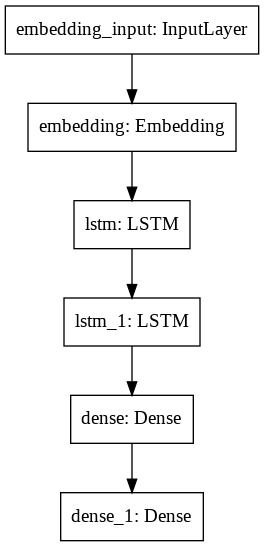

In [16]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile The Model:

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Fit The Model:

In [19]:
model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - 17s 220ms/step - loss: 7.8751

Epoch 00001: loss improved from inf to 7.87512, saving model to nextword1.h5
Epoch 2/150
61/61 [==============================] - 13s 217ms/step - loss: 7.8639

Epoch 00002: loss improved from 7.87512 to 7.86388, saving model to nextword1.h5
Epoch 3/150
61/61 [==============================] - 13s 214ms/step - loss: 7.8330

Epoch 00003: loss improved from 7.86388 to 7.83302, saving model to nextword1.h5
Epoch 4/150
61/61 [==============================] - 13s 214ms/step - loss: 7.6497

Epoch 00004: loss improved from 7.83302 to 7.64967, saving model to nextword1.h5
Epoch 5/150
61/61 [==============================] - 13s 212ms/step - loss: 7.4363

Epoch 00005: loss improved from 7.64967 to 7.43635, saving model to nextword1.h5
Epoch 6/150
61/61 [==============================] - 13s 214ms/step - loss: 7.2675

Epoch 00006: loss improved from 7.43635 to 7.26752, saving model to nextword1.h5
Epoch 7/150
61

### Graph:

In [22]:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# tensorboard --logdir="./logsnextword1"
# http://DESKTOP-U3TSCVT:6006/

from IPython.display import Image 
pil_img = Image(filename='graph1.png')
display(pil_img)

FileNotFoundError: ignored

## Observation:
### We are able to develop a decent next word prediction model and are able to get a declining loss and an overall decent performance.